In [2]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import as_strided
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.layers import Conv1D, AveragePooling1D, Flatten, Activation, Conv2D, BatchNormalization, Input, Concatenate, Dense, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-01-30 15:42:21.315111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738240941.336336  300318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738240941.342566  300318 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 15:42:21.363353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
file_path = 'data_extracted/1.csv'
data = pd.read_csv(file_path, header=None)

print(data[:2])

X = data[1].values.reshape(-1, 1)
y = data[2].astype(int)

        0         1  2
0  0.0001 -0.349114  0
1  0.0002 -0.244349  0


In [4]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Normalize the signal values
scaler = MinMaxScaler(feature_range = (0, 1))
#scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
window_size = 512
X_scaled_reshaped = as_strided(X_scaled, shape=(X_scaled.shape[0] - window_size + 1, window_size, 1), strides=(X_scaled.strides[0], X_scaled.strides[0], X_scaled.strides[1]))
y_updated = y[:-window_size+1]
y_encoded_updated = encoder.transform(y_updated.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y_encoded_updated, test_size=0.2, shuffle=False)

print(X_test.shape, y_test.shape)

(25898, 512, 1) (25898, 3)


In [6]:
model = Sequential()
#model.add(BatchNormalization(input_shape=(window_size, 1)))
# model.add(Conv1D(64, kernel_size=64, activation='relu', input_shape=(window_size, 1)))  # Convolutional layer
model.add(Conv1D(64, kernel_size=128, activation='relu'))  # Convolutional layer
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=32))  # Pooling layer
model.add(Conv1D(32, kernel_size=4, activation='relu'))  # Second convolutional layer
model.add(MaxPooling1D(pool_size=4))  # Second pooling layer
model.add(Flatten())  # Flatten the output
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])

2025-01-30 15:42:54.979683: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


class_weights = {0: 1, 1: 1, 2: 2}
model.fit(X_train, y_train, epochs=1, batch_size=100, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

829/829 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.9884 - loss: 0.0901 - recall: 0.9699 - val_accuracy: 0.9983 - val_loss: 0.0124 - val_recall: 0.9983
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9856 - loss: 0.0820 - recall: 0.9856
Test Loss: [0.05692075937986374, 0.9889566898345947, 0.9889566898345947]


In [7]:
X_test.shape

(25898, 512, 1)

In [14]:
y_test.shape

(25898,)

810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
(25898,)


ValueError: x and y can be no greater than 2D, but have shapes (25898,) and (25898, 512, 1)

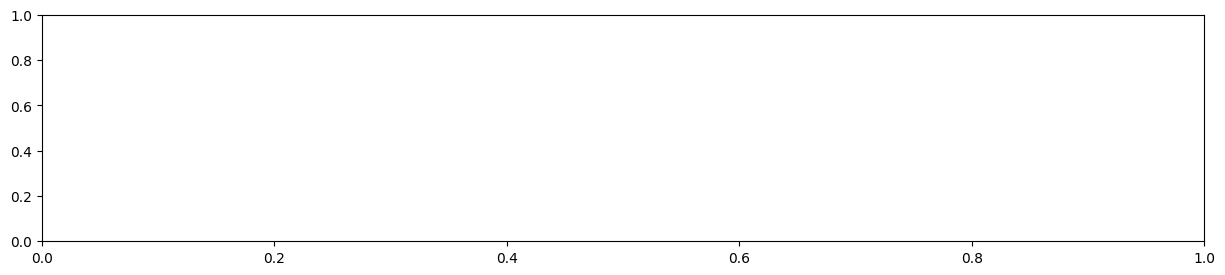

In [15]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes.shape)

plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test, label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(predicted_classes, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('my_model.h5')